In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
# packages for basic python calculation
import pandas as pd
import numpy as np
import os

# warning ignore
import warnings
warnings.filterwarnings("ignore")

# packages for fft
#import spectrum
#from spectrum import Periodogram, data_cosine

# packages for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE

from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# package for ploting
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

from random import sample 



# defind function for data readin
def load_data(folder_path = "../data/buy/"):
    df_gp = pd.DataFrame()
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"): 
            stock = filename[0:4]
            print("Loading stock data:", stock, ",")
            temp_df = pd.read_csv(os.path.join(folder_path, filename), delimiter= '\s+', header = None)
            temp_df.rename(columns={123:'rtn'}, inplace=True)
            temp_df = pd.concat([pd.Series([stock] * temp_df.shape[0], name = 'stock'), temp_df], axis=1)
            df_gp = pd.concat([df_gp, temp_df], ignore_index=True)
            df_gp.reset_index()
            continue
        else:
            continue
    
    # drop rows with NA
    rows_to_drop = []
    for i in range(df_gp.shape[0]):
        if sum(df_gp.iloc[i,:].isnull()):
            rows_to_drop.append(i)
    
    df_gp = df_gp.drop(rows_to_drop, axis=0)
    #df_gp = df_gp.iloc[:,1:]   
    
    # remove duplicates
    df_gp = df_gp.drop_duplicates(subset=df_gp.columns.difference(['stock']))
    
    # change data type
    df_gp.iloc[:, 1:] = df_gp.iloc[:, 1:].astype(float)
    
    df_gp = df_gp.reset_index(drop = True)
    return df_gp

Using TensorFlow backend.


# Data Loading

In [3]:
df_gp = load_data("/content/gdrive/My Drive/buy/")

Loading stock data: adbe ,
Loading stock data: ions ,
Loading stock data: ssys ,
Loading stock data: ati1 ,
Loading stock data: itub ,
Loading stock data: alny ,
Loading stock data: pxd1 ,
Loading stock data: ufs1 ,
Loading stock data: bac1 ,
Loading stock data: uri1 ,
Loading stock data: clf1 ,
Loading stock data: gs1B ,
Loading stock data: jnpr ,
Loading stock data: crm1 ,
Loading stock data: mas1 ,
Loading stock data: crus ,
Loading stock data: pru1 ,
Loading stock data: bidu ,
Loading stock data: fslr ,
Loading stock data: csiq ,
Loading stock data: jec1 ,
Loading stock data: db1B ,
Loading stock data: acad ,
Loading stock data: amd1 ,
Loading stock data: cenx ,
Loading stock data: teck ,
Loading stock data: meli ,


In [4]:
df_gp.head()

,stock,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,rtn
0,adbe,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,-1.55
1,adbe,-0.11,-0.12,-0.04,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,...,-0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,-0.57
2,adbe,-0.12,-0.13,-0.11,-0.10,-0.11,-0.12,-0.04,0.04,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,...,-0.10,-0.10,-0.09,-0.11,-0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00
3,adbe,-0.15,-0.20,-0.12,-0.13,-0.11,-0.10,-0.11,-0.12,-0.04,0.04,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.0,...,-0.07,-0.09,-0.10,-0.10,-0.09,-0.11,-0.07,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,5.70
4,adbe,-1.36,-1.56,-1.53,-1.34,-0.95,-0.53,0.24,1.05,1.62,2.24,2.68,3.05,3.4,3.64,3.69,3.63,3.38,3.15,2.94,2.45,1.88,1.45,0.9,0.51,0.34,0.14,-0.1,-0.15,-0.2,-0.12,-0.13,-0.11,-0.1,-0.11,-0.12,-0.04,0.04,0.0,0.0,...,-0.27,-0.29,-0.28,-0.18,-0.06,0.01,0.06,0.08,0.09,0.13,0.14,0.14,0.14,0.2,0.31,0.37,0.41,0.44,0.39,0.36,0.25,0.2,0.18,0.11,-0.01,-0.03,-0.05,-0.07,-0.09,-0.1,-0.1,-0.09,-0.11,-0.07,0.0,0.0,0.0,0.0,0.0,-1.22


In [0]:
# seperate indicators and returns
# name_gp = df_gp.iloc[:, 0]
osc_gp = df_gp.iloc[:, 1:42]
stk_gp = df_gp.iloc[:, 42:83]
macd_gp = df_gp.iloc[:, 83:124]
rtn_gp = df_gp.iloc[:, 124]
label_gp = np.sign(rtn_gp)
label_gp = label_gp.map({1: 1, -1: 0, 0:0})
results_gp = label_gp.map({1: 'EARN', 0: 'LOSS'})
label_gp = pd.DataFrame({"label": label_gp})

# Convert data to array

In [0]:
samples_full = []
for i in range(osc_gp.shape[0]):
  osc_list = osc_gp.iloc[i,:].tolist()
  stk_list = stk_gp.iloc[i,:].tolist()
  macd_list = macd_gp.iloc[i,:].tolist()
  temp_array = np.array((osc_list, stk_list, macd_list), dtype=float)
  samples_full.append(temp_array)

In [0]:
# this cell is delated

In [0]:
sample_y_full = label_gp["label"].tolist()
# complete dataset
X = np.array(samples_full)
y = np.array(sample_y_full)

# Train/test split

In [0]:
X = np.transpose(X, (0,2,1))

In [10]:
X.shape

(102408, 41, 3)

In [11]:
y.shape

(102408,)

In [0]:
# get the index for validation set
index_val = sample(list(range(X.shape[0])), int(X.shape[0]*0.2))
# get the index for train set
index_train = list(set(list(range(X.shape[0]))) - set(index_val))

In [46]:
len(index_val)

20481

In [47]:
len(index_train)

81927

In [0]:
# the training dataset
sample_X_train = list(samples_full[i] for i in index_train)
sample_y_train = list(sample_y_full[i] for i in index_train)
sample_X_train = np.transpose(sample_X_train, (0,2,1))

# the test dataset
sample_X_val = list(samples_full[i] for i in index_val)
sample_y_val = list(sample_y_full[i] for i in index_val)
sample_X_val = np.transpose(sample_X_val, (0,2,1))


In [0]:
X_train = np.array(sample_X_train)
y_train = np.array(sample_y_train)
X_val = np.array(sample_X_val)
y_val = np.array(sample_y_val)

# Test the array with CNN

In [0]:
from keras.datasets import mnist

from keras.layers import Dense, Dropout, Flatten, Activation, Conv1D, MaxPooling1D, GlobalAveragePooling2D,BatchNormalization, Conv2D,MaxPooling2D

from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, SGD

from keras.preprocessing.image import img_to_array, load_img

from keras.utils import np_utils
from keras.applications.inception_v3 import InceptionV3

In [0]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape = (41,3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])



In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 39, 64)            640       
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 19, 64)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1216)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 200)               243400    
_________________________________________________________________
dense_17 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 201       
Total params: 284,441
Trainable params: 284,441
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.fit(X_train,y_train,
      validation_data=(X_val,y_val),
      epochs=5,
      verbose=True) 


Train on 81927 samples, validate on 20481 samples
Epoch 1/5
81927/81927 [==============================] - 20s 244us/step - loss: 0.6949 - acc: 0.5840 - val_loss: 0.6759 - val_acc: 0.5919
Epoch 2/5
81927/81927 [==============================] - 20s 239us/step - loss: 0.6769 - acc: 0.5891 - val_loss: 0.6758 - val_acc: 0.5920
Epoch 3/5
81927/81927 [==============================] - 20s 239us/step - loss: 0.6770 - acc: 0.5891 - val_loss: 0.6762 - val_acc: 0.5919
Epoch 4/5
81927/81927 [==============================] - 20s 244us/step - loss: 0.6762 - acc: 0.5895 - val_loss: 0.6762 - val_acc: 0.5919
Epoch 5/5
81927/81927 [==============================] - 19s 234us/step - loss: 0.6764 - acc: 0.5897 - val_loss: 0.6757 - val_acc: 0.5919


In [54]:
df = pd.DataFrame(model.predict_classes(X_val), columns=["pre"])
df[df["pre"] == 1]

,pre
13204,1


In [57]:
sum(model.predict(X_val) > 0.5)


array([1])

# The position of the flatten layer and reactive function might matter

## Test the optimizer

### SGD

In [59]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape = (41,3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="sgd", loss='binary_crossentropy', metrics=['accuracy'])
 

model.fit(X_train,y_train,
      validation_data=(X_val,y_val),
      epochs=5,
      verbose=True) 

df = pd.DataFrame(model.predict_classes(X_val), columns=["pre"])
df[df["pre"] >0]

Train on 81927 samples, validate on 20481 samples
Epoch 1/5
81927/81927 [==============================] - 16s 199us/step - loss: 0.7089 - acc: 0.5871 - val_loss: 0.6760 - val_acc: 0.5919
Epoch 2/5
81927/81927 [==============================] - 16s 192us/step - loss: 0.6767 - acc: 0.5895 - val_loss: 0.6760 - val_acc: 0.5920
Epoch 3/5
81927/81927 [==============================] - 15s 188us/step - loss: 0.6765 - acc: 0.5896 - val_loss: 0.6761 - val_acc: 0.5921
Epoch 4/5
81927/81927 [==============================] - 16s 191us/step - loss: 0.6764 - acc: 0.5893 - val_loss: 0.6760 - val_acc: 0.5921
Epoch 5/5
81927/81927 [==============================] - 16s 189us/step - loss: 0.6763 - acc: 0.5897 - val_loss: 0.6757 - val_acc: 0.5921


,pre
2064,1
4106,1
5162,1
6296,1
8064,1
8848,1
9150,1
12795,1
13350,1


### Adagrad

In [60]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape = (41,3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adagrad", loss='binary_crossentropy', metrics=['accuracy'])


model.fit(X_train,y_train,
      validation_data=(X_val,y_val),
      epochs=5,
      verbose=True) 

df = pd.DataFrame(model.predict_classes(X_val), columns=["pre"])
df[df["pre"] >0]

Train on 81927 samples, validate on 20481 samples
Epoch 1/5
81927/81927 [==============================] - 20s 242us/step - loss: 0.8862 - acc: 0.5825 - val_loss: 0.6773 - val_acc: 0.5920
Epoch 2/5
81927/81927 [==============================] - 20s 240us/step - loss: 0.6765 - acc: 0.5888 - val_loss: 0.6780 - val_acc: 0.5822
Epoch 3/5
81927/81927 [==============================] - 20s 242us/step - loss: 0.6760 - acc: 0.5891 - val_loss: 0.6767 - val_acc: 0.5887
Epoch 4/5
81927/81927 [==============================] - 19s 230us/step - loss: 0.6755 - acc: 0.5892 - val_loss: 0.6759 - val_acc: 0.5915
Epoch 5/5
81927/81927 [==============================] - 19s 238us/step - loss: 0.6752 - acc: 0.5897 - val_loss: 0.6756 - val_acc: 0.5919


,pre
1113,1
2686,1
4086,1
4106,1
8848,1
9150,1
11082,1
12259,1
12795,1
13350,1


### Nadam

In [61]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape = (41,3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="nadam", loss='binary_crossentropy', metrics=['accuracy'])


model.fit(X_train,y_train,
      validation_data=(X_val,y_val),
      epochs=3,
      verbose=True) 

df = pd.DataFrame(model.predict_classes(X_val), columns=["pre"])
df[df["pre"] >0]

Train on 81927 samples, validate on 20481 samples
Epoch 1/3
81927/81927 [==============================] - 25s 303us/step - loss: 0.7510 - acc: 0.5861 - val_loss: 0.6768 - val_acc: 0.5916
Epoch 2/3
81927/81927 [==============================] - 24s 288us/step - loss: 0.6768 - acc: 0.5894 - val_loss: 0.6755 - val_acc: 0.5919
Epoch 3/3
81927/81927 [==============================] - 24s 293us/step - loss: 0.6769 - acc: 0.5895 - val_loss: 0.6763 - val_acc: 0.5918


,pre
6081,1
6296,1


As we can observe from above, changing the optimum function does not changes the acc very much but influence the amount of 1 prediction. 

# The upper results look promissing, we could combine the data with the sell data

In [62]:
df_gp_sell = load_data("/content/gdrive/My Drive/sell/")

Loading stock data: fslr ,
Loading stock data: csiq ,
Loading stock data: bidu ,
Loading stock data: pxdS ,
Loading stock data: masS ,
Loading stock data: uriS ,
Loading stock data: ufsS ,
Loading stock data: cenx ,
Loading stock data: meli ,
Loading stock data: pruS ,
Loading stock data: lvsS ,
Loading stock data: crus ,
Loading stock data: crmS ,
Loading stock data: itub ,
Loading stock data: alny ,
Loading stock data: teck ,
Loading stock data: dbSe ,
Loading stock data: amdS ,
Loading stock data: acad ,
Loading stock data: adbe ,
Loading stock data: ions ,
Loading stock data: ssys ,
Loading stock data: adsk ,
Loading stock data: atiS ,


In [63]:
df_gp_sell.head(5)

,stock,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,rtn
0,fslr,-0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.12
1,fslr,-1.72,-1.63,-1.66,-1.61,-1.52,-1.41,-1.30,-1.24,-1.13,-0.98,-0.81,-0.74,-0.71,-0.65,-0.64,-0.60,-0.50,-0.44,-0.38,-0.27,-0.14,-0.09,-0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-1.34,-1.59,-1.60,-1.97,-1.96,-2.24,-2.19,-1.45,0.12,0.44,0.27,-0.39,-0.69,-0.57,0.12,0.08,-0.31,-0.60,-0.21,-0.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.49
2,fslr,0.05,0.15,-0.04,-0.17,-0.53,-0.79,-1.03,-1.30,-1.47,-1.81,-1.95,-2.10,-2.16,-2.37,-2.64,-2.67,-2.76,-2.63,-2.53,-2.45,-2.32,-2.10,-1.78,-1.72,-1.63,-1.66,-1.61,-1.52,-1.41,-1.30,-1.24,-1.13,-0.98,-0.81,-0.74,-0.71,-0.65,-0.64,-0.60,...,-2.46,-2.93,-3.79,-4.00,-4.57,-3.74,-1.66,0.60,1.17,0.96,1.32,1.05,-0.50,-1.57,-2.91,-3.73,-4.09,-4.05,-3.10,-1.88,0.12,0.29,0.15,-1.34,-1.59,-1.60,-1.97,-1.96,-2.24,-2.19,-1.45,0.12,0.44,0.27,-0.39,-0.69,-0.57,0.12,0.08,0.06
3,fslr,0.05,0.10,0.05,0.15,-0.04,-0.17,-0.53,-0.79,-1.03,-1.30,-1.47,-1.81,-1.95,-2.10,-2.16,-2.37,-2.64,-2.67,-2.76,-2.63,-2.53,-2.45,-2.32,-2.10,-1.78,-1.72,-1.63,-1.66,-1.61,-1.52,-1.41,-1.30,-1.24,-1.13,-0.98,-0.81,-0.74,-0.71,-0.65,...,-1.56,-2.07,-2.46,-2.93,-3.79,-4.00,-4.57,-3.74,-1.66,0.60,1.17,0.96,1.32,1.05,-0.50,-1.57,-2.91,-3.73,-4.09,-4.05,-3.10,-1.88,0.12,0.29,0.15,-1.34,-1.59,-1.60,-1.97,-1.96,-2.24,-2.19,-1.45,0.12,0.44,0.27,-0.39,-0.69,-0.57,-1.11
4,fslr,0.38,0.38,0.37,0.29,0.21,0.07,-0.05,-0.11,-0.04,0.05,0.10,0.05,0.15,-0.04,-0.17,-0.53,-0.79,-1.03,-1.30,-1.47,-1.81,-1.95,-2.10,-2.16,-2.37,-2.64,-2.67,-2.76,-2.63,-2.53,-2.45,-2.32,-2.10,-1.78,-1.72,-1.63,-1.66,-1.61,-1.52,...,3.46,2.17,1.35,0.07,0.16,-1.27,-1.17,-1.33,-1.08,-1.56,-2.07,-2.46,-2.93,-3.79,-4.00,-4.57,-3.74,-1.66,0.60,1.17,0.96,1.32,1.05,-0.50,-1.57,-2.91,-3.73,-4.09,-4.05,-3.10,-1.88,0.12,0.29,0.15,-1.34,-1.59,-1.60,-1.97,-1.96,-2.93


Here good return is actually represent going down of the stk, the prediction of the model will be focusing on whether the stock is going up or down. Thus, we convert the sign of rtn.

In [66]:
df_gp_sell["rtn"] = -1*df_gp_sell["rtn"]
df_gp_sell.head()

,stock,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,rtn
0,fslr,-0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.12
1,fslr,-1.72,-1.63,-1.66,-1.61,-1.52,-1.41,-1.30,-1.24,-1.13,-0.98,-0.81,-0.74,-0.71,-0.65,-0.64,-0.60,-0.50,-0.44,-0.38,-0.27,-0.14,-0.09,-0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,-1.34,-1.59,-1.60,-1.97,-1.96,-2.24,-2.19,-1.45,0.12,0.44,0.27,-0.39,-0.69,-0.57,0.12,0.08,-0.31,-0.60,-0.21,-0.41,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-1.49
2,fslr,0.05,0.15,-0.04,-0.17,-0.53,-0.79,-1.03,-1.30,-1.47,-1.81,-1.95,-2.10,-2.16,-2.37,-2.64,-2.67,-2.76,-2.63,-2.53,-2.45,-2.32,-2.10,-1.78,-1.72,-1.63,-1.66,-1.61,-1.52,-1.41,-1.30,-1.24,-1.13,-0.98,-0.81,-0.74,-0.71,-0.65,-0.64,-0.60,...,-2.46,-2.93,-3.79,-4.00,-4.57,-3.74,-1.66,0.60,1.17,0.96,1.32,1.05,-0.50,-1.57,-2.91,-3.73,-4.09,-4.05,-3.10,-1.88,0.12,0.29,0.15,-1.34,-1.59,-1.60,-1.97,-1.96,-2.24,-2.19,-1.45,0.12,0.44,0.27,-0.39,-0.69,-0.57,0.12,0.08,-0.06
3,fslr,0.05,0.10,0.05,0.15,-0.04,-0.17,-0.53,-0.79,-1.03,-1.30,-1.47,-1.81,-1.95,-2.10,-2.16,-2.37,-2.64,-2.67,-2.76,-2.63,-2.53,-2.45,-2.32,-2.10,-1.78,-1.72,-1.63,-1.66,-1.61,-1.52,-1.41,-1.30,-1.24,-1.13,-0.98,-0.81,-0.74,-0.71,-0.65,...,-1.56,-2.07,-2.46,-2.93,-3.79,-4.00,-4.57,-3.74,-1.66,0.60,1.17,0.96,1.32,1.05,-0.50,-1.57,-2.91,-3.73,-4.09,-4.05,-3.10,-1.88,0.12,0.29,0.15,-1.34,-1.59,-1.60,-1.97,-1.96,-2.24,-2.19,-1.45,0.12,0.44,0.27,-0.39,-0.69,-0.57,1.11
4,fslr,0.38,0.38,0.37,0.29,0.21,0.07,-0.05,-0.11,-0.04,0.05,0.10,0.05,0.15,-0.04,-0.17,-0.53,-0.79,-1.03,-1.30,-1.47,-1.81,-1.95,-2.10,-2.16,-2.37,-2.64,-2.67,-2.76,-2.63,-2.53,-2.45,-2.32,-2.10,-1.78,-1.72,-1.63,-1.66,-1.61,-1.52,...,3.46,2.17,1.35,0.07,0.16,-1.27,-1.17,-1.33,-1.08,-1.56,-2.07,-2.46,-2.93,-3.79,-4.00,-4.57,-3.74,-1.66,0.60,1.17,0.96,1.32,1.05,-0.50,-1.57,-2.91,-3.73,-4.09,-4.05,-3.10,-1.88,0.12,0.29,0.15,-1.34,-1.59,-1.60,-1.97,-1.96,2.93


In [85]:
df = pd.concat([df_gp, df_gp_sell]).reset_index(drop = True)
print(df.shape, df_gp.shape, df_gp_sell.shape)

(189247, 125) (102408, 125) (86839, 125)


Here, the newly concat dataframe' rtn represents the movement of the stock market data. We can then study the distribution of the rtn values and determine the threshold.

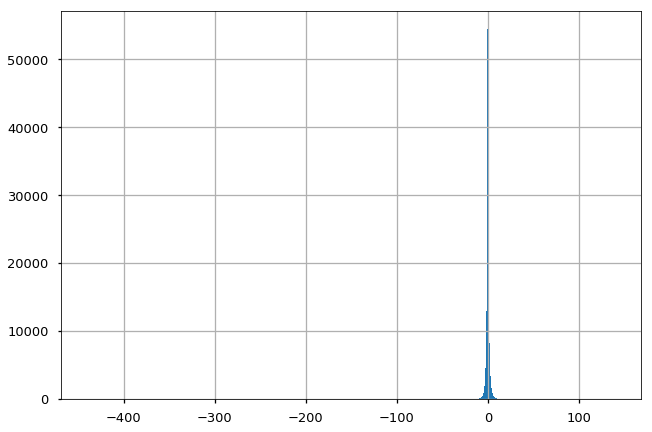

In [86]:
df["rtn"].hist(bins = 1000)
# the plot is so peaky due to the outliers

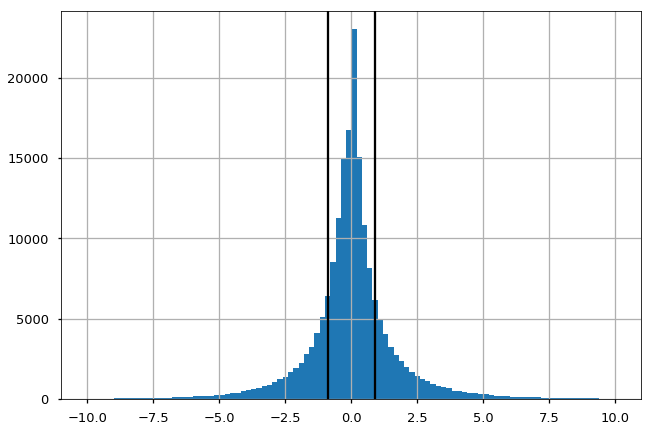

In [87]:
df_cleaned = df[abs(df["rtn"]) < 10]
df_cleaned["rtn"].hist(bins = 100)
# it looks like a normal dist?
# i would use the mean +/- 1/2sd as the two threshold for up, unsure, and down
thre_up = df_cleaned["rtn"].mean() + 0.5*df_cleaned["rtn"].std()
thre_down = df_cleaned["rtn"].mean() - 0.5*df_cleaned["rtn"].std()
plt.axvline(x=thre_up, color = "black")
plt.axvline(x = thre_down, color = "black")

In [0]:
df_down = df[df["rtn"] < thre_down]
df_up = df[df["rtn"] > thre_up]
df_avg = df[(df["rtn"] < thre_up) &(df["rtn"] > thre_down)]

In [93]:
print(df_down.shape, df_up.shape, df_avg.shape)

(37100, 125) (36708, 125) (115439, 125)


In [132]:
df_down["mov"] = -1
df_up["mov"] = 1
df_avg["mov"] = 0

df = pd.concat([df_down, df_up, df_avg]).reset_index(drop = True)

from sklearn.utils import shuffle
df = shuffle(df)


df.head()

,stock,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,rtn,mov
38909,ssys,-1.22,-1.24,-1.20,-1.09,-1.04,-1.04,-1.12,-1.13,-1.03,-1.01,-0.98,-0.99,-0.90,-0.70,-0.51,-0.29,-0.16,0.01,0.13,0.23,0.29,0.31,0.36,0.31,0.37,0.39,0.36,0.32,0.31,0.32,0.29,0.39,0.48,0.53,0.65,0.79,0.82,0.76,0.68,...,-0.20,-0.21,-0.16,-0.27,-0.35,-0.34,-0.30,-0.33,-0.36,-0.42,-0.44,-0.40,-0.34,-0.29,-0.24,-0.19,-0.08,-0.04,-0.10,-0.04,-0.03,0.10,0.20,0.27,0.33,0.35,0.33,0.25,0.18,0.10,0.05,-0.06,-0.02,0.02,0.06,0.15,0.15,0.16,0.92,1
135309,meli,1.90,1.85,1.86,1.92,1.83,1.74,1.72,1.63,1.55,1.46,1.32,1.13,0.99,0.77,0.38,-0.01,-0.34,-0.62,-0.85,-1.09,-1.27,-1.43,-1.45,-1.42,-1.34,-1.36,-1.36,-1.01,-0.74,-0.41,-0.07,0.22,0.46,0.76,1.06,0.98,0.96,0.85,0.81,...,1.08,1.03,0.89,0.73,0.52,0.65,1.36,2.17,2.25,2.29,2.08,1.44,0.85,0.44,0.28,0.12,-0.04,0.02,-0.01,-0.33,-0.50,-0.67,-0.83,-1.06,-1.21,-1.95,-2.40,-2.37,-1.83,-1.27,-0.55,-0.10,-0.14,-0.31,-0.20,-0.22,0.15,0.40,0.21,0
7863,uri1,-3.82,-3.86,-3.66,-3.41,-3.10,-3.19,-3.54,-3.43,-3.40,-3.19,-2.77,-2.38,-1.98,-1.59,-0.82,-0.55,-0.36,-0.19,-0.25,0.01,-0.17,-0.53,-1.06,-1.57,-2.13,-2.51,-2.93,-3.54,-3.67,-3.49,-3.28,-2.86,-2.48,-2.12,-1.47,-0.81,-0.32,0.12,0.42,...,-0.73,-0.30,-0.19,-0.18,-0.17,-0.26,-0.35,-0.38,-0.32,-0.31,-0.30,-0.32,-0.30,-0.30,-0.20,-0.20,-0.04,0.09,0.44,0.45,0.51,0.58,0.65,0.53,0.06,-0.11,-0.20,-0.45,-0.53,-0.60,-0.64,-0.64,-0.57,-0.47,-0.25,-0.07,-0.03,0.05,-2.01,-1
40325,itub,-2.12,-2.17,-2.11,-1.95,-1.78,-1.52,-1.31,-0.93,-0.41,-0.17,-0.06,-0.14,-0.18,-0.25,-0.35,-0.63,-0.96,-1.13,-1.24,-1.21,-1.37,-1.51,-1.56,-1.24,-0.83,-0.47,-0.10,0.26,0.72,1.18,1.52,1.48,1.40,1.31,1.14,0.99,0.71,0.42,0.25,...,-0.07,-0.06,-0.10,-0.12,-0.15,-0.13,-0.13,-0.11,-0.11,-0.11,-0.10,-0.06,-0.04,-0.01,0.04,0.01,-0.01,-0.03,-0.07,-0.10,-0.14,-0.17,-0.19,-0.21,-0.22,-0.17,-0.08,-0.00,-0.00,-0.02,-0.02,-0.02,-0.02,-0.01,-0.03,-0.05,-0.07,-0.07,5.51,1
72440,adsk,1.05,1.08,1.05,0.92,0.82,0.72,0.58,0.42,0.30,0.25,0.29,0.34,0.39,0.45,0.52,0.61,0.75,0.87,0.95,1.09,1.26,1.42,1.52,1.48,1.46,1.40,1.36,1.34,1.32,1.28,1.29,1.36,1.37,1.36,1.22,0.96,0.59,0.24,-0.07,...,-0.19,-0.25,-0.04,-0.16,-0.51,-0.65,-0.79,-0.72,-0.59,-0.61,-0.66,-0.89,-1.22,-1.26,-1.27,-0.90,-0.56,0.10,0.65,1.36,2.05,2.64,2.86,3.18,3.27,2.77,2.04,1.35,1.89,2.31,2.63,2.90,2.97,2.87,2.84,2.44,2.27,2.22,14.86,1


In [0]:
# because repeating the same code for multiple times is so boring to me...
def generating_train_test(df_gp):
  
  osc_gp = df_gp.iloc[:, 1:42]
  stk_gp = df_gp.iloc[:, 42:83]
  macd_gp = df_gp.iloc[:, 83:124]
  
  # convert data to array
  samples_full = []
  for i in range(osc_gp.shape[0]):
    osc_list = osc_gp.iloc[i,:].tolist()
    stk_list = stk_gp.iloc[i,:].tolist()
    macd_list = macd_gp.iloc[i,:].tolist()
    temp_array = np.array((osc_list, stk_list, macd_list), dtype=float)
    samples_full.append(temp_array)
  
  #print(len(samples_full))
  print("Now the data are converted to arrays")
 
  # get the index for validation set
  index_val = sample(list(range(df_gp.shape[0])), int(df_gp.shape[0]*0.2))
  # get the index for train set
  index_train = list(set(list(range(df_gp.shape[0]))) - set(index_val))
   
  #print("Now We generated the index for train and validation")
  # get the train and validation
  samples_y_full = df_gp["mov"].tolist()
  # the training dataset
  sample_X_train = list(samples_full[i] for i in index_train)
  sample_y_train = list(samples_y_full[i] for i in index_train)
  sample_X_train = np.transpose(sample_X_train, (0,2,1))
  
  print("We finished the spliting and transposing of Training dataset")

  # the validation dataset
  sample_X_val = list(samples_full[i] for i in index_val)
  sample_y_val = list(samples_y_full[i] for i in index_val)
  sample_X_val = np.transpose(sample_X_val, (0,2,1))
  print("We finished the spliting and transposing of validation dataset")

  X_train = np.array(sample_X_train)
  y_train = np.array(sample_y_train)
  X_val = np.array(sample_X_val)
  y_val = np.array(sample_y_val)

  return X_train, y_train, X_val, y_val

In [134]:
X_train, y_train, X_val, y_val = generating_train_test(df)

Now the data are converted to arrays
We finished the spliting and transposing of Training dataset
We finished the spliting and transposing of validation dataset


In [140]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape = (41,3)))
model.add(MaxPooling1D(pool_size=6))
model.add(Flatten())
model.add(Dense(50, activation='tanh'))
# model.add(Dropout(0.3))
model.add(Dense(50, activation='tanh'))
model.add(Dense(1, activation='softmax'))
model.compile(optimizer="adam", loss='squared_hinge', metrics=['accuracy'])


model.fit(X_train,y_train,
      validation_data=(X_val,y_val),
      epochs=5,
      verbose=True) 

#df = pd.DataFrame(model.predict_classes(X_val), columns=["pre"])
#df[df["pre"] >0]

Train on 151398 samples, validate on 37849 samples
Epoch 1/5
151398/151398 [==============================] - 20s 131us/step - loss: 1.3932 - acc: 0.1943 - val_loss: 1.3981 - val_acc: 0.1927
Epoch 2/5
151398/151398 [==============================] - 18s 118us/step - loss: 1.3932 - acc: 0.1943 - val_loss: 1.3981 - val_acc: 0.1927
Epoch 3/5
151398/151398 [==============================] - 19s 125us/step - loss: 1.3932 - acc: 0.1943 - val_loss: 1.3981 - val_acc: 0.1927
Epoch 4/5
151398/151398 [==============================] - 18s 121us/step - loss: 1.3932 - acc: 0.1943 - val_loss: 1.3981 - val_acc: 0.1927
Epoch 5/5
151398/151398 [==============================] - 18s 121us/step - loss: 1.3932 - acc: 0.1943 - val_loss: 1.3981 - val_acc: 0.1927


The model structure that works fine for binary prediction seems does not work at all for multiclass...need some time to train a new structure maybe?

In [145]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape = (41,3)))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(1, activation='tanh'))
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='squared_hinge', optimizer=opt, metrics=['accuracy'])

model.fit(X_train,y_train,
      validation_data=(X_val,y_val),
      epochs=3) 



Train on 151398 samples, validate on 37849 samples
Epoch 1/3
151398/151398 [==============================] - 19s 128us/step - loss: 1.3932 - acc: 0.1943 - val_loss: 1.3981 - val_acc: 0.1927
Epoch 2/3
151398/151398 [==============================] - 17s 115us/step - loss: 1.3932 - acc: 0.1943 - val_loss: 1.3981 - val_acc: 0.1927
Epoch 3/3
151398/151398 [==============================] - 17s 115us/step - loss: 1.3932 - acc: 0.1943 - val_loss: 1.3981 - val_acc: 0.1927


# Introducing the sell data does not really help with the case..what about look sell data alone



In [3]:
df_gp_sell = load_data("/content/gdrive/My Drive/sell/")

Loading stock data: csiq ,
Loading stock data: fslr ,
Loading stock data: bidu ,
Loading stock data: lvsS ,
Loading stock data: uriS ,
Loading stock data: masS ,
Loading stock data: pxdS ,
Loading stock data: crmS ,
Loading stock data: crus ,
Loading stock data: pruS ,
Loading stock data: meli ,
Loading stock data: cenx ,
Loading stock data: ufsS ,
Loading stock data: acad ,
Loading stock data: amdS ,
Loading stock data: dbSe ,
Loading stock data: teck ,
Loading stock data: alny ,
Loading stock data: itub ,
Loading stock data: atiS ,
Loading stock data: adsk ,
Loading stock data: ssys ,
Loading stock data: ions ,
Loading stock data: adbe ,
Loading stock data: gsSe ,
Loading stock data: clfS ,
Loading stock data: bacS ,


In [0]:
# because repeating the same code for multiple times is so boring to me...
def generating_train_test(df_gp):
  
  osc_gp = df_gp.iloc[:, 1:42]
  stk_gp = df_gp.iloc[:, 42:83]
  macd_gp = df_gp.iloc[:, 83:124]
  rtn_gp = df_gp.iloc[:, 124]
  label_gp = np.sign(rtn_gp)
  label_gp = label_gp.map({1: 1, -1: 0, 0:0})
  results_gp = label_gp.map({1: 'EARN', 0: 'LOSS'})
  label_gp = pd.DataFrame({"label": label_gp})
  
  print("Starting converting data to arrays")
  # convert data to array
  samples_full = []
  for i in range(osc_gp.shape[0]):
    osc_list = osc_gp.iloc[i,:].tolist()
    stk_list = stk_gp.iloc[i,:].tolist()
    macd_list = macd_gp.iloc[i,:].tolist()
    temp_array = np.array((osc_list, stk_list, macd_list), dtype=float)
    samples_full.append(temp_array)
  
  #print(len(samples_full))
  print("Now the data are converted to arrays")
 
  # get the index for validation set
  index_val = sample(list(range(df_gp.shape[0])), int(df_gp.shape[0]*0.2))
  # get the index for train set
  index_train = list(set(list(range(df_gp.shape[0]))) - set(index_val))
   
  print("Now We generated the index for train and validation")
  # get the train and validation
  sample_y_full = label_gp["label"].tolist()
  # the training dataset
  sample_X_train = list(samples_full[i] for i in index_train)
  sample_y_train = list(sample_y_full[i] for i in index_train)
  sample_X_train = np.transpose(sample_X_train, (0,2,1))
  
  print("We finished the spliting and transposing of Training dataset")

  # the validation dataset
  sample_X_val = list(samples_full[i] for i in index_val)
  sample_y_val = list(sample_y_full[i] for i in index_val)
  sample_X_val = np.transpose(sample_X_val, (0,2,1))
  print("We finished the spliting and transposing of validation dataset")

  X_train = np.array(sample_X_train)
  y_train = np.array(sample_y_train)
  X_val = np.array(sample_X_val)
  y_val = np.array(sample_y_val)

  return X_train, y_train, X_val, y_val

In [151]:
X_train, y_train, X_val, y_val = generating_train_test(df_gp_sell)

Starting converting data to arrays
Now the data are converted to arrays
Now We generated the index for train and validation
We finished the spliting and transposing of Training dataset
We finished the spliting and transposing of validation dataset


In [152]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape = (41,3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="nadam", loss='binary_crossentropy', metrics=['accuracy'])


model.fit(X_train,y_train,
      validation_data=(X_val,y_val),
      epochs=3,
      verbose=True) 

df = pd.DataFrame(model.predict_classes(X_val), columns=["pre"])
df[df["pre"] >0]

Train on 82043 samples, validate on 20510 samples
Epoch 1/3
82043/82043 [==============================] - 28s 344us/step - loss: 0.7509 - acc: 0.5969 - val_loss: 0.6754 - val_acc: 0.5951
Epoch 2/3
82043/82043 [==============================] - 25s 305us/step - loss: 0.6738 - acc: 0.6006 - val_loss: 0.6758 - val_acc: 0.5944
Epoch 3/3
82043/82043 [==============================] - 25s 301us/step - loss: 0.6744 - acc: 0.6007 - val_loss: 0.6755 - val_acc: 0.5945


,pre
2210,1
3500,1
4566,1
4990,1
5685,1
6502,1
7538,1
8078,1
9543,1
11064,1


# conclusion:

As demonstrated above, the model works seperately instead of combining.

# We then can further explore the predicted results
## For Buy data

previous results lost due to internet disconnect...poor google colab...so start from reading data again

In [4]:
data_buy = load_data("/content/gdrive/My Drive/buy/")

Loading stock data: adbe ,
Loading stock data: ions ,
Loading stock data: ssys ,
Loading stock data: ati1 ,
Loading stock data: itub ,
Loading stock data: alny ,
Loading stock data: pxd1 ,
Loading stock data: ufs1 ,
Loading stock data: bac1 ,
Loading stock data: uri1 ,
Loading stock data: clf1 ,
Loading stock data: gs1B ,
Loading stock data: jnpr ,
Loading stock data: crm1 ,
Loading stock data: mas1 ,
Loading stock data: crus ,
Loading stock data: pru1 ,
Loading stock data: bidu ,
Loading stock data: fslr ,
Loading stock data: csiq ,
Loading stock data: jec1 ,
Loading stock data: db1B ,
Loading stock data: acad ,
Loading stock data: amd1 ,
Loading stock data: cenx ,
Loading stock data: teck ,
Loading stock data: meli ,


In [24]:
X_train, y_train, X_val, y_val = generating_train_test(data_buy)

Starting converting data to arrays
Now the data are converted to arrays
Now We generated the index for train and validation
We finished the spliting and transposing of Training dataset
We finished the spliting and transposing of validation dataset


In [39]:
model = Sequential()
model.add(Conv1D(filters=5, kernel_size=3, activation='relu', input_shape = (41,3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(164, activation='relu'))

model.add(Dense(1, activation='relu'))
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train,y_train,
      validation_data=(X_val,y_val),
      epochs=5,
      verbose=True) 

Train on 81927 samples, validate on 20481 samples
Epoch 1/5
81927/81927 [==============================] - 11s 129us/step - loss: 6.5910 - acc: 0.5909 - val_loss: 6.6610 - val_acc: 0.5867
Epoch 2/5
81927/81927 [==============================] - 9s 115us/step - loss: 6.5929 - acc: 0.5910 - val_loss: 6.6610 - val_acc: 0.5867
Epoch 3/5
81927/81927 [==============================] - 9s 116us/step - loss: 6.5929 - acc: 0.5910 - val_loss: 6.6610 - val_acc: 0.5867
Epoch 4/5
81927/81927 [==============================] - 9s 116us/step - loss: 6.5929 - acc: 0.5910 - val_loss: 6.6610 - val_acc: 0.5867
Epoch 5/5
81927/81927 [==============================] - 9s 116us/step - loss: 6.5929 - acc: 0.5910 - val_loss: 6.6610 - val_acc: 0.5867


In [0]:
df = pd.DataFrame(model.predict(X_val), columns=["pre"])
df["true"] = y_val

# Other things to try

1. We could explore the influence of data balancing to the train data
2. We could explore the possibility of seting class weights
3. We could explore the influence of data normalizing to the train data
4. We could further explore the results with more detailed classification, greater upper, upper, average, lower, and great low by combining the sell data together

### Data balancing

There are more loss than gain in the original dataset if we look

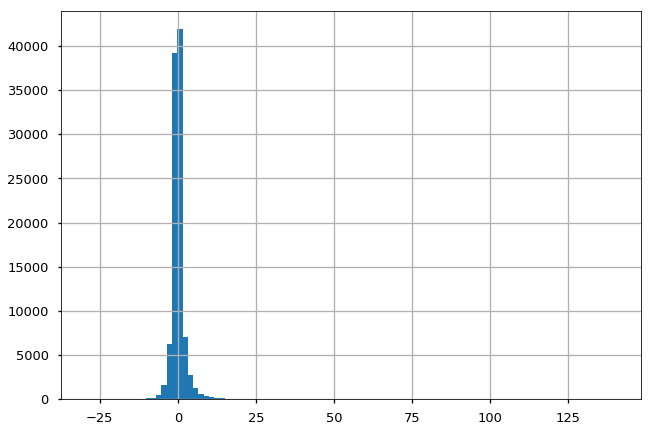

In [27]:
rtn_gp.hist(bins = 100)

In [28]:
print("The percentage of rtn lower than 0 is," ,sum(rtn_gp < 0)/rtn_gp.shape[0])

The percentage of rtn lower than 0 is, 0.5548101710803843


Thus we can see there are more returns is lower than 0. We can mannully balance the dataset.

In [0]:
from sklearn.utils import shuffle

data_buy_pos = data_buy[data_buy["rtn"] > 0]
data_buy_neg = data_buy[data_buy["rtn"] <= 0]
#print("gain len", data_buy_pos.shape[0])
#print("loss len", data_buy_neg.shape[0])

data_buy_pos_sub = data_buy_pos
data_buy_neg_sub = data_buy_neg.sample(n = data_buy_pos.shape[0])

data_balance = data_buy_pos_sub.append(data_buy_neg_sub, ignore_index=True)
data_balance = shuffle(data_balance)
#data_combine = data_combine.reset_index(drop = True)
#data_combine

Here, instead of df_gp, we have data_ban as our new dataset and all the classes are balanced.\
\

In [0]:
# because repeating the same code for multiple times is so boring to me...
def generating_train_test(df_gp):
  
  osc_gp = df_gp.iloc[:, 1:42]
  stk_gp = df_gp.iloc[:, 42:83]
  macd_gp = df_gp.iloc[:, 83:124]
  rtn_gp = df_gp.iloc[:, 124]
  label_gp = np.sign(rtn_gp)
  label_gp = label_gp.map({1: 1, -1: 0, 0:0})
  results_gp = label_gp.map({1: 'EARN', 0: 'LOSS'})
  label_gp = pd.DataFrame({"label": label_gp})
  
  print("Starting converting data to arrays")
  # convert data to array
  samples_full = []
  for i in range(osc_gp.shape[0]):
    osc_list = osc_gp.iloc[i,:].tolist()
    stk_list = stk_gp.iloc[i,:].tolist()
    macd_list = macd_gp.iloc[i,:].tolist()
    temp_array = np.array((osc_list, stk_list, macd_list), dtype=float)
    samples_full.append(temp_array)
  
  #print(len(samples_full))
  print("Now the data are converted to arrays")
 
  # get the index for validation set
  index_val = sample(list(range(df_gp.shape[0])), int(df_gp.shape[0]*0.2))
  # get the index for train set
  index_train = list(set(list(range(df_gp.shape[0]))) - set(index_val))
   
  print("Now We generated the index for train and validation")
  # get the train and validation
  sample_y_full = label_gp["label"].tolist()
  # the training dataset
  sample_X_train = list(samples_full[i] for i in index_train)
  sample_y_train = list(sample_y_full[i] for i in index_train)
  sample_X_train = np.transpose(sample_X_train, (0,2,1))
  
  print("We finished the spliting and transposing of Training dataset")

  # the validation dataset
  sample_X_val = list(samples_full[i] for i in index_val)
  sample_y_val = list(sample_y_full[i] for i in index_val)
  # what if we do not use the transpose
  sample_X_val = np.transpose(sample_X_val, (0,2,1))
  print("We finished the spliting and transposing of validation dataset")

  X_train = np.array(sample_X_train)
  y_train = np.array(sample_y_train)
  X_val = np.array(sample_X_val)
  y_val = np.array(sample_y_val)

  return X_train, y_train, X_val, y_val

In [87]:
# for the balanced datase
X_train, y_train, X_val, y_val = generating_train_test(data_balance)

Starting converting data to arrays
Now the data are converted to arrays
Now We generated the index for train and validation
We finished the spliting and transposing of Training dataset
We finished the spliting and transposing of validation dataset


We will use the same model setting and to explore the difference

In [59]:
model = Sequential()
model.add(Conv1D(filters=5, kernel_size=3, activation='relu', input_shape = (41,3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(164, activation='relu'))

model.add(Dense(1, activation='relu'))
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
 

model.fit(X_train,y_train,
      validation_data=(X_val,y_val),
      epochs=5,
      verbose=True) 

Train on 67160 samples, validate on 16790 samples
Epoch 1/5
67160/67160 [==============================] - 10s 152us/step - loss: 8.0698 - acc: 0.4993 - val_loss: 8.0158 - val_acc: 0.5027
Epoch 2/5
67160/67160 [==============================] - 8s 123us/step - loss: 8.0698 - acc: 0.4993 - val_loss: 8.0158 - val_acc: 0.5027
Epoch 3/5
67160/67160 [==============================] - 8s 123us/step - loss: 8.0698 - acc: 0.4993 - val_loss: 8.0158 - val_acc: 0.5027
Epoch 4/5
67160/67160 [==============================] - 8s 124us/step - loss: 8.0698 - acc: 0.4993 - val_loss: 8.0158 - val_acc: 0.5027
Epoch 5/5
67160/67160 [==============================] - 8s 122us/step - loss: 8.0698 - acc: 0.4993 - val_loss: 8.0158 - val_acc: 0.5027


In [61]:
df = pd.DataFrame(model.predict_classes(X_val), columns=["pre"])
df[df["pre"] > 0]


,pre


After balancing the data, the model performance actually goes down...It could be because the original model is more intended to predict 0 instead of 1, and balancing actually reduce the useful data?

## What about defining different class weights

In [88]:
# We still using the original dataset (unbalanced one)

X_train, y_train, X_val, y_val = generating_train_test(data_buy)

Starting converting data to arrays
Now the data are converted to arrays
Now We generated the index for train and validation
We finished the spliting and transposing of Training dataset
We finished the spliting and transposing of validation dataset


In [0]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [92]:
model = Sequential()
model.add(Conv1D(filters=164, kernel_size=3, activation='relu', input_shape = (41,3)))
model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train,y_train,
      validation_data=(X_val,y_val),
      epochs=10,
      batch_size=32,
      verbose=True,
      class_weight=class_weights) 

Train on 81927 samples, validate on 20481 samples
Epoch 1/10
81927/81927 [==============================] - 24s 288us/step - loss: 0.7105 - acc: 0.5800 - val_loss: 0.6774 - val_acc: 0.5897
Epoch 2/10
81927/81927 [==============================] - 20s 249us/step - loss: 0.6766 - acc: 0.5896 - val_loss: 0.6761 - val_acc: 0.5896
Epoch 3/10
81927/81927 [==============================] - 20s 247us/step - loss: 0.6764 - acc: 0.5899 - val_loss: 0.6757 - val_acc: 0.5896
Epoch 4/10
81927/81927 [==============================] - 20s 250us/step - loss: 0.6761 - acc: 0.5896 - val_loss: 0.6764 - val_acc: 0.5898
Epoch 5/10
81927/81927 [==============================] - 21s 251us/step - loss: 0.6760 - acc: 0.5901 - val_loss: 0.6766 - val_acc: 0.5898
Epoch 6/10
81927/81927 [==============================] - 20s 250us/step - loss: 0.6759 - acc: 0.5901 - val_loss: 0.6764 - val_acc: 0.5897
Epoch 7/10
81927/81927 [==============================] - 20s 250us/step - loss: 0.6759 - acc: 0.5900 - val_loss: 0.

In [64]:
df = pd.DataFrame(model.predict_classes(X_val), columns=["predication"])
df["true"]
df[df["predication"] == 1]


,predication,true
0,1,1
1,1,1
2,1,0
3,1,0
4,1,0
5,1,1
6,1,0
7,1,1
8,1,1
9,1,0


In [0]:
# explore the prediction distribution


In [107]:
# what if we put more weights in the 1 class
class_weight = {0: 1.,
                1: 2.}

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape = (41,3)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.3)) 
model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])


model.fit(X_train, y_train, 
          validation_data=(X_val,y_val),
          epochs=10, 
          class_weight=class_weights)


Train on 81927 samples, validate on 20481 samples
Epoch 1/10
81927/81927 [==============================] - 26s 323us/step - loss: 0.7015 - acc: 0.5833 - val_loss: 0.6767 - val_acc: 0.5898
Epoch 2/10
81927/81927 [==============================] - 24s 290us/step - loss: 0.6772 - acc: 0.5894 - val_loss: 0.6759 - val_acc: 0.5898
Epoch 3/10
81927/81927 [==============================] - 23s 278us/step - loss: 0.6763 - acc: 0.5901 - val_loss: 0.6758 - val_acc: 0.5898
Epoch 4/10
81927/81927 [==============================] - 24s 289us/step - loss: 0.6764 - acc: 0.5900 - val_loss: 0.6756 - val_acc: 0.5897
Epoch 5/10
81927/81927 [==============================] - 24s 293us/step - loss: 0.6763 - acc: 0.5901 - val_loss: 0.6764 - val_acc: 0.5895
Epoch 6/10
81927/81927 [==============================] - 25s 299us/step - loss: 0.6762 - acc: 0.5901 - val_loss: 0.6757 - val_acc: 0.5896
Epoch 7/10
81927/81927 [==============================] - 24s 295us/step - loss: 0.6762 - acc: 0.5902 - val_loss: 0.


# Conv1d vs.Conv2d

In [108]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape = (41,3)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.3)) 
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, 
          validation_data=(X_val,y_val),
          epochs=5, 
          class_weight=class_weights)

Train on 81927 samples, validate on 20481 samples
Epoch 1/5
81927/81927 [==============================] - 34s 409us/step - loss: 0.6919 - acc: 0.5885 - val_loss: 0.6773 - val_acc: 0.5896
Epoch 2/5
81927/81927 [==============================] - 30s 362us/step - loss: 0.6767 - acc: 0.5900 - val_loss: 0.6761 - val_acc: 0.5898
Epoch 3/5
81927/81927 [==============================] - 29s 360us/step - loss: 0.6766 - acc: 0.5902 - val_loss: 0.6763 - val_acc: 0.5896
Epoch 4/5
81927/81927 [==============================] - 30s 367us/step - loss: 0.6761 - acc: 0.5902 - val_loss: 0.6755 - val_acc: 0.5897
Epoch 5/5
81927/81927 [==============================] - 30s 369us/step - loss: 0.6764 - acc: 0.5901 - val_loss: 0.6766 - val_acc: 0.5899


In [0]:
# 2d doesnot really work for this case


# Because this is time series, we could also add LSTM layer


In [109]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape = (41,3)))
model.add(Conv1D(filters=64, kernel_size=8, activation='relu'))
model.add(LSTM(32, return_sequences=True))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(200, activation='relu'))
# model.add(Dropout(0.3)) 
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, 
          validation_data=(X_val,y_val),
          epochs=5, 
          class_weight=class_weights)

model.summary()

Train on 81927 samples, validate on 20481 samples
Epoch 1/5
81927/81927 [==============================] - 97s 1ms/step - loss: 0.6787 - acc: 0.5875 - val_loss: 0.6756 - val_acc: 0.5898
Epoch 2/5
81927/81927 [==============================] - 93s 1ms/step - loss: 0.6769 - acc: 0.5902 - val_loss: 0.6795 - val_acc: 0.5898
Epoch 3/5
81927/81927 [==============================] - 92s 1ms/step - loss: 0.6772 - acc: 0.5898 - val_loss: 0.6759 - val_acc: 0.5898
Epoch 4/5
81927/81927 [==============================] - 93s 1ms/step - loss: 0.6763 - acc: 0.5902 - val_loss: 0.6763 - val_acc: 0.5898
Epoch 5/5
81927/81927 [==============================] - 93s 1ms/step - loss: 0.6764 - acc: 0.5902 - val_loss: 0.6757 - val_acc: 0.5898
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_82 (Conv1D)           (None, 39, 64)            640       
_________________________________________________________________
conv1d

Ok, one last thing for today i want to try is **Normalizing** !

# Normalizing

Because the next step is concat, and too tired to write the normalizing code again...I just use the class obj defined before

In [0]:
class OSC_analyzing_pipeline():
    
    """
    This class is designed and modified for the Seahorse program. It is applicable for Random Forest
    Classifier originally.
    
    Attributes:
    ----------------------------------------------------------------------------
    self.data: the input dataset that we will be using for training and testing
    self.model: the classifier we want to explore
    self.osc_gp: subset for the oscillator data
    * new addition: self.stk: subset for original stock data
    self.macd_gp: subset for the macd data
    self.rtn_gp: subset for the return values
    self.label_gp: the output for training and testing (the reponse variable)
    
    self.psd
    self.smooth
    self.first_derivitive_macd
    self.second_derivitive_macd
    self.first_derivitive_osc
    self.second_derivitive_osc
    self.partial_smooth
    
    self.feature_result_df: the feature matrix and label generated from the feature_generator function, it can be used to visual which feature is participated in model training
    self.X_train: to visual and further call the training dataset
    self.X_test: to visual and further call the test dataset
    self.y_train: to visual and further call the training dataset
    self.y_test: to visual and further call the test dataset
    
    self.report: generate the report to compare the winning rate with the original test
    The class object also contains all the attributes belongs to the model/classifier originally.
    
    Functions:
    ----------------------------------------------------------------------------
    * new addition: EDA_visualization(): function for visualization the record
    psd_calculator(): function calculate the fft values, callable with return value to be visualized
    smooth_calculator(): function for calculating the smoothness value, already modified and can handle the amplitude changes
    derivative_calculator(): function for calculating the derivitive for macd and osc
    features_generator(): function to decide which feature can be used in the final model training, the input is True/False for certain feature to be involved. In this function, all three function above will be called
    model_train(): training the model based on the feature matrix
    
    """
    
    # define the init
    def __init__(self, data):
        """
        Keyword argument:
        data -- (df) the input dataset for processing
        model -- (ML model) the classifier we are interested of, currently it is just the random forest
        """
        self.data = data
        
        # seperate indicators and returns
        # name_gp = df_gp.iloc[:, 0]
        self.osc_gp = self.data.iloc[:, 1:42]
        self.stk_gp = self.data.iloc[:, 42:83]
        self.macd_gp = self.data.iloc[:, 83:124]
        self.rtn_gp = self.data.iloc[:, 124]
        self.label_gp = np.sign(self.rtn_gp)
        self.label_gp = self.label_gp.map({1: 1, -1: 0, 0:0})
        self.results_gp = self.label_gp.map({1: 'EARN', 0: 'LOSS'})
        self.label_gp = pd.DataFrame({"label": self.label_gp})
        
    
    def EDA_visualization(self, index, osc_ind = True, stk_ind = False, macd_ind = False):
        if osc_ind:
            # plot Oscillator
            plt.figure(figsize=(12,4))
            plt.plot(range(41),  self.osc_gp.iloc[index,:])
            plt.gca().invert_xaxis()
            plt.axhline(y=0.0, color = "black",linestyle='--')
            plt.ylabel("Oscillator")
            plt.xlabel("Time")
            plt.title("Oscillator 3-Day Time Series")
            plt.show()
        

        if stk_ind:
            # plot stock price
            plt.figure(figsize=(12,4))
            plt.plot(range(41), self.stk_gp.iloc[index,:])
            plt.legend()
            plt.gca().invert_xaxis()
            plt.ylabel("Stock Price")
            plt.xlabel("Time")
            plt.title("Stock Price 3-Day Time Series")
            plt.show()
    
        if macd_ind:
        # plot MACD
            plt.figure(figsize=(12,4))
            plt.plot(range(41),  self.macd_gp.iloc[index,:])
            plt.legend()
            plt.gca().invert_xaxis()
            plt.axhline(y=0.0, color = "black",linestyle='--')
            plt.ylabel("MACD")
            plt.xlabel("Time")
            plt.title("MACD 3-Day Time Series")
            plt.show()
        
    # define function for psd calculation
    # define function to calculate smoothness more directly
    def smooth_calculator(self):
        smooth_list = []
        for i in range(self.osc_gp.shape[0]):
            amp = np.mean(abs(self.osc_gp.iloc[i,:]))
            if amp == 0:
                smooth_list.append(0)
            else:
                smooth_list.append(np.var(np.diff(self.osc_gp.iloc[i,:]))/amp)
        
        smooth = pd.DataFrame(smooth_list, columns=["smooth"]) 
        smooth.index = self.osc_gp.index

        return smooth
    
    # define the function to explore the influence of partial smoothness
    def smooth_partial(self):
        # get the nearest 10 points
        osc_10 = self.osc_gp.iloc[:,-10:]
        # calculate the smoothness of 10 points
        smooth_10 = []
        for i in range(osc_10.shape[0]):
            amp = np.mean(abs(osc_10.iloc[i,:]))
            if amp == 0:
                smooth_10.append(0)
            else:
                smooth_10.append(np.var(np.diff(osc_10.iloc[i,:]))/amp)
        
        
        # get the nearest 20 points
        osc_20 = self.osc_gp.iloc[:,-20:]
        smooth_20 = []
        for i in range(osc_20.shape[0]):
            amp = np.mean(abs(osc_20.iloc[i,:]))
            if amp == 0:
                smooth_20.append(0)
            else:
                smooth_20.append(np.var(np.diff(osc_20.iloc[i,:]))/(np.mean(abs(osc_20.iloc[i,:]))))
        
        # get the nearest 30 points
        osc_30 = self.osc_gp.iloc[:,-30:]
        smooth_30 = []
        for i in range(osc_30.shape[0]):
            amp = np.mean(abs(osc_30.iloc[i,:]))
            if amp == 0:
                smooth_30.append(0)
            else:
                smooth_30.append(np.var(np.diff(osc_30.iloc[i,:]))/(np.mean(abs(osc_30.iloc[i,:]))))
        
        partial_smooth = pd.DataFrame({"smooth_10": smooth_10,
                                      "smooth_20": smooth_20,
                                      "smooth_30": smooth_30,})
        
        partial_smooth.index = self.osc_gp.index
        return partial_smooth
    
    def amp_standardize(self, osc_std = True, stk_std = True, macd_std = True):
        
        # standardize osc
        if osc_std == True:
            norm_osc = []
            mean_amp = []
    
            for i in range(self.osc_gp.shape[0]):
                mean_amp_temp = np.mean(abs(self.osc_gp.iloc[i,:]))
                mean_amp.append(mean_amp_temp)
                if mean_amp == 0: 
                    std = lambda x: x*mean_amp_temp
                    norm_osc_temp_list = list(map(std, self.osc_gp.iloc[i,:].tolist()))
                    norm_osc.append(norm_osc_temp_list)
                else:
                    std = lambda x: x/mean_amp_temp
                    norm_osc_temp_list = list(map(std, self.osc_gp.iloc[i,:].tolist()))
                    norm_osc.append(norm_osc_temp_list)
            
    
            col_name = []
            for i in range(len(norm_osc[0])):
                col_name.append("std_osc"+str(i))
            
            amp_osc = pd.DataFrame(norm_osc, columns=col_name)
            amp_osc["mean_amp_osc"] = mean_amp
            amp_osc.index = self.osc_gp.index
        
        if stk_std == True:
            norm_stk = []
            mean_amp_stk = []
            
            for i in range(self.stk_gp.shape[0]):
                mean_amp_temp = np.mean(abs(self.stk_gp.iloc[i,:]))
                mean_amp_stk.append(mean_amp_temp)
                if mean_amp_temp == 0:
                    std = lambda x: x*mean_amp_temp
                    norm_stk_temp_list = list(map(std, self.stk_gp.iloc[i,:].tolist()))
                    norm_stk.append(norm_stk_temp_list)
                else:
                    std = lambda x: x/mean_amp_temp
                    norm_stk_temp_list = list(map(std, self.stk_gp.iloc[i,:].tolist()))
                    norm_stk.append(norm_stk_temp_list)
                    
            col_name = []
            for i in range(len(norm_stk[0])):
                col_name.append("std_stk"+str(i))
            
            amp_stk = pd.DataFrame(norm_stk, columns=col_name)
            amp_stk["mean_amp_stk"] = mean_amp_stk
            amp_stk.index = self.stk_gp.index
        
        if macd_std == True:
            norm_macd = []
            mean_amp_macd = []
            
            for i in range(self.macd_gp.shape[0]):
                mean_amp_temp = np.mean(abs(self.macd_gp.iloc[i,:]))
                mean_amp_macd.append(mean_amp_temp)
                if mean_amp_temp == 0:
                    std = lambda x: x*mean_amp_temp
                    norm_macd_temp_list = list(map(std, self.macd_gp.iloc[i,:].tolist()))
                    norm_macd.append(norm_macd_temp_list)
                else:
                    std = lambda x: x/mean_amp_temp
                    norm_macd_temp_list = list(map(std, self.macd_gp.iloc[i,:].tolist()))
                    norm_macd.append(norm_macd_temp_list)
                    
            col_name = []
            for i in range(len(norm_stk[0])):
                col_name.append("std_macd"+str(i))
            
            amp_macd = pd.DataFrame(norm_macd, columns=col_name)
            amp_macd["mean_amp_macd"] = mean_amp_macd
            amp_macd.index = self.macd_gp.index
            
        return amp_osc, amp_stk, amp_macd
    
    def first_derivative_calculator(self, space = 1, name = "macd"):
        
        
        if name == "macd":
            dy = []
            for i in range(self.macd_gp.shape[0]):
                y = pd.Series(self.macd_gp.iloc[i,:])
                temp_dy = list(np.gradient(y, space))
                dy.append(temp_dy)
    
            col_name = []
            for i in range(self.macd_gp.shape[1]):
                col_name.append(name + "deriv"+ str(i))
        
            deriv_df = pd.DataFrame(dy, columns=col_name) 
            deriv_df.index = self.macd_gp.index
            
        if name == "osc":
            dy = []
            for i in range(self.osc_gp.shape[0]):
                y = pd.Series(self.osc_gp.iloc[i,:])
                temp_dy = list(np.gradient(y, space))
                dy.append(temp_dy)
    
            col_name = []
            for i in range(self.osc_gp.shape[1]):
                col_name.append(name + "deriv"+ str(i))
        
            deriv_df = pd.DataFrame(dy, columns=col_name) 
            deriv_df.index = self.osc_gp.index
            
        if name == "stk":
            dy = []
            for i in range(self.stk_gp.shape[0]):
                y = pd.Series(self.stk_gp.iloc[i,:])
                temp_dy = list(np.gradient(y, space))
                dy.append(temp_dy)
    
            col_name = []
            for i in range(self.stk_gp.shape[1]):
                col_name.append(name + "deriv"+ str(i))
        
            deriv_df = pd.DataFrame(dy, columns=col_name) 
            deriv_df.index = self.stk_gp.index
        return deriv_df
    
    def second_derivative_calculator(self, space = 1, name = "macd"):
        
        if name == "macd":
            
            ddy = []
            for i in range(self.first_deriv_macd.shape[0]):
                y = pd.Series(self.first_deriv_macd.iloc[i,:])
                temp_ddy = list(np.gradient(y, space))
                ddy.append(temp_ddy)
    
            col_name = []
            for i in range(self.first_deriv_macd.shape[1]):
                col_name.append(name + "sec_deriv"+ str(i))
        
            sec_deriv_df = pd.DataFrame(ddy, columns=col_name) 
            sec_deriv_df.index = self.first_deriv_macd.index
        
        if name == "osc":
            
            ddy = []
            for i in range(self.first_deriv_osc.shape[0]):
                y = pd.Series(self.first_deriv_osc.iloc[i,:])
                temp_ddy = list(np.gradient(y, space))
                ddy.append(temp_ddy)
    
            col_name = []
            for i in range(self.first_deriv_osc.shape[1]):
                col_name.append(name + "sec_deriv"+ str(i))
        
            sec_deriv_df = pd.DataFrame(ddy, columns=col_name) 
            sec_deriv_df.index = self.first_deriv_osc.index
        
        
        return sec_deriv_df
    
    def var_stock_price(self):
        variance_stk = []
        for i in range(self.stk_gp.shape[0]):
            variance_stk.append(np.var(self.stk_gp.iloc[i,:]))
        
        variance = pd.DataFrame(variance_stk, columns=["stk_variance"]) 
        variance.index = self.stk_gp.index
        
        return variance
    
    def features_generator(self,
                           base_features = True,
                           smooth=True, 
                           standardize = True, 
                           curvature=True, 
                           derivative = True, 
                           partial_smooth = True, 
                           var_stk = True):
    # Feature order:
    # 0-40, osc;
    # 41-81, stk;
    # 82-122: macd;
    # 123-173: freq
    # 174: smooth
    # 175-215: first derivitive of osc
    # 216-256: second derivitive of osc
    # 257-297: first derivitive of macd
    # 297-338: second derivitive of macd
    
    
        self.stock = pd.DataFrame(self.data.stock)
        self.stock = pd.get_dummies(self.stock)
        self.stock.index = self.data.stock.index
        
        Feature_matrix = self.data.iloc[:,1:-1]
        Feature_matrix = pd.merge(Feature_matrix, self.stock, left_index=True, right_index=True)


        
        # print(Feature_matrix)
        # Feature_matrix = pd.concat([Feature_matrix, psd_osc])
    
    # Factor for smoothness
        if smooth==True:
            print("now generating smoothness")
            self.smooth_osc = self.smooth_calculator()
            Feature_matrix = pd.merge(Feature_matrix, self.smooth_osc, left_index=True, right_index=True)
        
        if standardize == True:
            print("Normalizing the original osc, stk, macd")
            self.std_osc, self.std_stk, self.std_macd = self.amp_standardize()
            Feature_matrix = pd.merge(Feature_matrix, self.std_osc, left_index=True, right_index=True)
            Feature_matrix = pd.merge(Feature_matrix, self.std_stk, left_index=True, right_index=True)
            Feature_matrix = pd.merge(Feature_matrix, self.std_macd, left_index=True, right_index=True)
            
            
        
    # Factor for curvature
        if curvature == True:
            print("now generating osc derivitives")
        # calculate the dy for osc (way to study curvature)
            self.first_deriv_osc = self.first_derivative_calculator(name = "osc")
            Feature_matrix = pd.merge(Feature_matrix, self.first_deriv_osc, left_index=True, right_index=True)
        # calculate the ddy for osc
            self.second_deriv_osc = self.second_derivative_calculator(name = "osc")
            Feature_matrix = pd.merge(Feature_matrix, self.second_deriv_osc, left_index=True, right_index=True)
        
    # MACD dirivative
        if derivative == True:
            print("now generating first derivitives")
            # calculate the dy for macd
            self.first_deriv_macd = self.first_derivative_calculator(name = "macd")
            Feature_matrix = pd.merge(Feature_matrix, self.first_deriv_macd, left_index=True, right_index=True)
        # calculate the ddy for macd
            self.second_deriv_macd = self.second_derivative_calculator(name = "macd")
            Feature_matrix = pd.merge(Feature_matrix, self.second_deriv_macd, left_index=True, right_index=True)
        # Feature_matrix = pd.concat([Feature_matrix, first_deriv_macd,second_deriv_macd])
            self.first_deriv_stk = self.first_derivative_calculator(name = "stk")
        
      
    
    # partial smoothness
        if partial_smooth == True:
            print("now generating partial smoothness")
            self.partial_smooth = self.smooth_partial()
            Feature_matrix = pd.merge(Feature_matrix, self.partial_smooth, left_index=True, right_index=True)
        
         # variance of stk
        if var_stk == True:
            print("now generating stk volatility")
            self.variance_stk = self.var_stock_price()
            Feature_matrix = pd.merge(Feature_matrix, self.variance_stk, left_index=True, right_index=True)
        
        if base_features == False:
            Feature_matrix = Feature_matrix.iloc[:,:123]
        
        self.feature_result_df = pd.merge(Feature_matrix, self.label_gp, left_index=True, right_index=True)

In [0]:
data_buy_norm = OSC_analyzing_pipeline(data_buy)

In [144]:
data_buy_norm.features_generator(False, False, True, False, False,False, False)

TypeError: ignored

In [0]:
std_macd = data_buy_norm.std_macd
std_osc = data_buy_norm.std_osc
std_stk = data_buy_norm.std_stk

samples_full = []
for i in range(std_osc.shape[0]):
    osc_list = std_osc.iloc[i,:].tolist()
    stk_list = std_stk.iloc[i,:].tolist()
    macd_list = std_macd.iloc[i,:].tolist()
    temp_array = np.array((osc_list, stk_list, macd_list), dtype=float)
    samples_full.append(temp_array)
    
# get the index for validation set
index_val = sample(list(range(std_macd.shape[0])), int(std_macd.shape[0]*0.2))
# get the index for train set
index_train = list(set(list(range(std_macd.shape[0]))) - set(index_val))


# get the train and validation
sample_y_full = data_buy_norm.label_gp["label"].tolist()
  # the training dataset
sample_X_train = list(samples_full[i] for i in index_train)
sample_y_train = list(sample_y_full[i] for i in index_train)
sample_X_train = np.transpose(sample_X_train, (0,2,1))


sample_X_val = list(samples_full[i] for i in index_val)
sample_y_val = list(sample_y_full[i] for i in index_val)
  # what if we do not use the transpose
sample_X_val = np.transpose(sample_X_val, (0,2,1))


X_train = np.array(sample_X_train)
y_train = np.array(sample_y_train)
X_val = np.array(sample_X_val)
y_val = np.array(sample_y_val)



In [139]:
model = Sequential()
model.add(Conv1D(filters=164, kernel_size=3, activation='relu', input_shape = (42,3)))
model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train,y_train,
      validation_data=(X_val,y_val),
      epochs=10,
      batch_size=32,
      verbose=True) 

Train on 81927 samples, validate on 20481 samples
Epoch 1/10
81927/81927 [==============================] - 35s 428us/step - loss: 0.6793 - acc: 0.5890 - val_loss: 0.6772 - val_acc: 0.5865
Epoch 2/10
81927/81927 [==============================] - 31s 383us/step - loss: 0.6760 - acc: 0.5910 - val_loss: 0.6776 - val_acc: 0.5866
Epoch 3/10
81927/81927 [==============================] - 30s 367us/step - loss: 0.6755 - acc: 0.5911 - val_loss: 0.6772 - val_acc: 0.5866
Epoch 4/10
81927/81927 [==============================] - 30s 370us/step - loss: 0.6752 - acc: 0.5910 - val_loss: 0.6770 - val_acc: 0.5866
Epoch 5/10
81927/81927 [==============================] - 30s 368us/step - loss: 0.6750 - acc: 0.5911 - val_loss: 0.6774 - val_acc: 0.5866
Epoch 6/10
81927/81927 [==============================] - 28s 347us/step - loss: 0.6748 - acc: 0.5911 - val_loss: 0.6771 - val_acc: 0.5866
Epoch 7/10
81927/81927 [==============================] - 31s 377us/step - loss: 0.6748 - acc: 0.5911 - val_loss: 0.

# No, No, No!!! What about concat????

There are other features we considered in other models, the psd, smoothness, first and second derivitive and so on. We could use those features to build the model seperately and concat them together. 

In [153]:
data_buy_norm.features_generator()

now generating smoothness
Normalizing the original osc, stk, macd
now generating osc derivitives
now generating first derivitives
now generating partial smoothness
now generating stk volatility


In [156]:
data_length = data_buy_norm.data.shape[0]
# smoothness
smoothness = data_buy_norm.smooth_osc

print("start processing the basic")
# sample for original data
samples_full_basic = []
for i in range(data_buy_norm.osc_gp.shape[0]):
    osc_list = data_buy_norm.osc_gp.iloc[i,:].tolist()
    stk_list = data_buy_norm.stk_gp.iloc[i,:].tolist()
    macd_list = data_buy_norm.macd_gp.iloc[i,:].tolist()
    temp_array = np.array((osc_list, stk_list, macd_list), dtype=float)
    samples_full_basic.append(temp_array)


print("start processing the deriv")

# sample for first derivitives for those three time series
samples_full_deriv = []
for i in range(data_buy_norm.first_deriv_macd.shape[0]):
    osc_list = data_buy_norm.first_deriv_osc.iloc[i,:].tolist()
    stk_list = data_buy_norm.first_deriv_stk.iloc[i,:].tolist()
    macd_list = data_buy_norm.first_deriv_macd.iloc[i,:].tolist()
    temp_array = np.array((osc_list, stk_list, macd_list), dtype=float)
    samples_full_deriv.append(temp_array)
    
print("start processing the norm")

# sample for normalizing data    
samples_full_norm = []
for i in range(data_buy_norm.std_osc.shape[0]):
    osc_list = data_buy_norm.std_osc.iloc[i,:].tolist()
    stk_list = data_buy_norm.std_stk.iloc[i,:].tolist()
    macd_list = data_buy_norm.std_macd.iloc[i,:].tolist()
    temp_array = np.array((osc_list, stk_list, macd_list), dtype=float)
    samples_full_norm.append(temp_array)
    



start processing the basic
start processing the deriv
start processing the norm


In [160]:
print("creating index")
# get the index for validation set
index_val = sample(list(range(data_length)), int(data_length*0.2))
# get the index for train set
index_train = list(set(list(range(data_length))) - set(index_val))


print("train/test split for y")
# get the train and validation for y
sample_y_full = data_buy_norm.label_gp["label"].tolist()
sample_y_train = list(sample_y_full[i] for i in index_train)
sample_y_val = list(sample_y_full[i] for i in index_val)
y_train = np.array(sample_y_train)
y_val = np.array(sample_y_val)


print("train/test split for sample_basic")                   
# the training dataset for original dataset_ basic three factor
sample_X_train_basic = list(samples_full_basic[i] for i in index_train)
sample_X_train_basic = np.transpose(sample_X_train_basic, (0,2,1))
sample_X_val_basic = list(samples_full_basic[i] for i in index_val)
# what if we do not use the transpose
sample_X_val_basic = np.transpose(sample_X_val_basic, (0,2,1))
X_train_basic = np.array(sample_X_train_basic)
X_val_basic = np.array(sample_X_val_basic)

print("train/test spilt for sample_norm")
# the training dataset for normalized dataset_ norm three factor
sample_X_train_norm = list(samples_full_norm[i] for i in index_train)
sample_X_train_norm = np.transpose(sample_X_train_norm, (0,2,1))
sample_X_val_norm = list(samples_full_norm[i] for i in index_val)
# what if we do not use the transpose
sample_X_val_norm = np.transpose(sample_X_val_norm, (0,2,1))
X_train_norm = np.array(sample_X_train_norm)
X_val_norm = np.array(sample_X_val_norm)

print("train/test spilt for sample_deriv")

# # the training dataset for derivative dataset_ deriv three factor
sample_X_train_deriv = list(samples_full_deriv[i] for i in index_train)
sample_X_train_deriv = np.transpose(sample_X_train_deriv, (0,2,1))
sample_X_val_deriv = list(samples_full_deriv[i] for i in index_val)
# what if we do not use the transpose
sample_X_val_deriv = np.transpose(sample_X_val_deriv, (0,2,1))
X_train_deriv = np.array(sample_X_train_deriv)
X_val_deriv = np.array(sample_X_val_deriv)


print("train/test spilt for sample_smooth")

# the train/test for smoothness data  
sample_X_train_smooth = smoothness.ix[index_train]

sample_X_val_smooth = smoothness.ix[index_val]
# what if we do not use the transpose
X_train_smooth = np.array(sample_X_train_smooth)
X_val_smooth = np.array(sample_X_val_smooth)

creating index
train/test split for y
train/test split for sample_basic
train/test spilt for sample_norm
train/test spilt for sample_deriv
train/test spilt for sample_smooth


In [171]:
X_val_deriv.shape

(20481, 41, 3)

Exam model for each feature individually

In [165]:
# for basic
convnet_basic_ts = Sequential()
convnet_basic_ts.add(Conv1D(filters=164, kernel_size=8, activation='relu', input_shape = (41,3)))
convnet_basic_ts.add(MaxPooling1D(pool_size=2))
convnet_basic_ts.add(Flatten())
convnet_basic_ts.add(Dense(50, activation='relu'))
convnet_basic_ts.add(Dense(1, activation='sigmoid'))

convnet_basic_ts.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])


convnet_basic_ts.fit(
    X_train_basic,y_train,
    validation_data=(X_val_basic,y_val),
    epochs=5,
verbose=True)



Train on 81927 samples, validate on 20481 samples
Epoch 1/5
81927/81927 [==============================] - 38s 460us/step - loss: 0.7086 - acc: 0.5832 - val_loss: 0.6798 - val_acc: 0.5879
Epoch 2/5
81927/81927 [==============================] - 32s 391us/step - loss: 0.6776 - acc: 0.5900 - val_loss: 0.6782 - val_acc: 0.5879
Epoch 3/5
81927/81927 [==============================] - 35s 433us/step - loss: 0.6764 - acc: 0.5906 - val_loss: 0.6775 - val_acc: 0.5878
Epoch 4/5
81927/81927 [==============================] - 36s 433us/step - loss: 0.6764 - acc: 0.5905 - val_loss: 0.6778 - val_acc: 0.5868
Epoch 5/5
81927/81927 [==============================] - 36s 439us/step - loss: 0.6762 - acc: 0.5904 - val_loss: 0.6778 - val_acc: 0.5879


In [170]:
# for norm
convnet_norm_ts = Sequential()
convnet_norm_ts.add(Conv1D(filters=164, kernel_size=8, activation='relu', input_shape = (42,3)))
convnet_norm_ts.add(MaxPooling1D(pool_size=2))
convnet_norm_ts.add(Flatten())
convnet_norm_ts.add(Dense(50, activation='relu'))
convnet_norm_ts.add(Dense(1, activation='sigmoid'))

convnet_norm_ts.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])


convnet_norm_ts.fit(
    X_train_norm,y_train,
    validation_data=(X_val_norm,y_val),
    epochs=5,
verbose=True)



Train on 81927 samples, validate on 20481 samples
Epoch 1/5
81927/81927 [==============================] - 38s 470us/step - loss: 0.6783 - acc: 0.5896 - val_loss: 0.6777 - val_acc: 0.5880
Epoch 2/5
81927/81927 [==============================] - 32s 392us/step - loss: 0.6771 - acc: 0.5906 - val_loss: 0.6782 - val_acc: 0.5880
Epoch 3/5
81927/81927 [==============================] - 33s 397us/step - loss: 0.6766 - acc: 0.5907 - val_loss: 0.6774 - val_acc: 0.5880
Epoch 4/5
81927/81927 [==============================] - 31s 381us/step - loss: 0.6765 - acc: 0.5907 - val_loss: 0.6775 - val_acc: 0.5878
Epoch 5/5
81927/81927 [==============================] - 32s 387us/step - loss: 0.6764 - acc: 0.5907 - val_loss: 0.6774 - val_acc: 0.5879


In [172]:
convnet_deriv_ts = Sequential()
convnet_deriv_ts.add(Conv1D(filters=164, kernel_size=8, activation='relu', input_shape = (41,3)))
convnet_deriv_ts.add(MaxPooling1D(pool_size=2))
convnet_deriv_ts.add(Flatten())
convnet_deriv_ts.add(Dense(50, activation='relu'))
convnet_deriv_ts.add(Dense(1, activation='sigmoid'))

convnet_deriv_ts.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])


convnet_deriv_ts.fit(
    X_train_deriv,y_train,
    validation_data=(X_val_deriv,y_val),
    epochs=5,
verbose=True)



Train on 81927 samples, validate on 20481 samples
Epoch 1/5
81927/81927 [==============================] - 27s 329us/step - loss: 0.6776 - acc: 0.5901 - val_loss: 0.6771 - val_acc: 0.5879
Epoch 2/5
81927/81927 [==============================] - 22s 272us/step - loss: 0.6762 - acc: 0.5904 - val_loss: 0.6764 - val_acc: 0.5879
Epoch 3/5
81927/81927 [==============================] - 23s 275us/step - loss: 0.6755 - acc: 0.5907 - val_loss: 0.6767 - val_acc: 0.5879
Epoch 4/5
81927/81927 [==============================] - 23s 279us/step - loss: 0.6753 - acc: 0.5907 - val_loss: 0.6761 - val_acc: 0.5879
Epoch 5/5
81927/81927 [==============================] - 23s 276us/step - loss: 0.6749 - acc: 0.5907 - val_loss: 0.6762 - val_acc: 0.5879


In [177]:
model_smooth = Sequential()
model_smooth.add(Dense(output_dim =224, activation = 'relu', input_dim = 1))
#model_smooth.add(Dense(output_dim = 12, activation = "relu"))
model_smooth.add(Dense(output_dim = 1, activation = 'sigmoid'))

model_smooth.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model_smooth.fit(X_train_smooth, y_train,
                validation_data = (X_val_smooth, y_val),
                epochs = 5,
                verbose = True)

Train on 81927 samples, validate on 20481 samples
Epoch 1/5
81927/81927 [==============================] - 10s 121us/step - loss: 0.6769 - acc: 0.5905 - val_loss: 0.6777 - val_acc: 0.5879
Epoch 2/5
81927/81927 [==============================] - 6s 71us/step - loss: 0.6768 - acc: 0.5907 - val_loss: 0.6777 - val_acc: 0.5879
Epoch 3/5
81927/81927 [==============================] - 6s 71us/step - loss: 0.6767 - acc: 0.5907 - val_loss: 0.6777 - val_acc: 0.5879
Epoch 4/5
81927/81927 [==============================] - 6s 71us/step - loss: 0.6768 - acc: 0.5907 - val_loss: 0.6777 - val_acc: 0.5879
Epoch 5/5
81927/81927 [==============================] - 6s 71us/step - loss: 0.6766 - acc: 0.5907 - val_loss: 0.6782 - val_acc: 0.5879


In [176]:
model_smooth.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_144 (Dense)            (None, 24)                48        
_________________________________________________________________
dense_145 (Dense)            (None, 1)                 25        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


In [191]:
# test if following code works
convnet_basic_ts_in = Input(shape=(41,3))
convnet_basic_ts_dense_1 = Conv1D(filters=164, kernel_size=8, activation='relu', input_shape = (41,3))(convnet_basic_ts_in)
convnet_basic_ts_dense_2 = MaxPooling1D(pool_size=2)(convnet_basic_ts_dense_1)
convnet_basic_ts_dense_3 = Flatten()(convnet_basic_ts_dense_2)
convnet_basic_ts_dense_4 = Dense(50, activation='relu')(convnet_basic_ts_dense_3)
convnet_basic_ts_dense_out = Dense(1, activation = "sigmoid")(convnet_basic_ts_dense_4)
model1 = Model(convnet_basic_ts_in, convnet_basic_ts_dense_out)
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model1.fit(X_train_basic, y_train,
                validation_data = (X_val_basic, y_val),
                epochs = 5,
                verbose = True)

Train on 81927 samples, validate on 20481 samples
Epoch 1/5
81927/81927 [==============================] - 28s 337us/step - loss: 0.6974 - acc: 0.5849 - val_loss: 0.6788 - val_acc: 0.5876
Epoch 2/5
81927/81927 [==============================] - 22s 271us/step - loss: 0.6769 - acc: 0.5906 - val_loss: 0.6775 - val_acc: 0.5880
Epoch 3/5
81927/81927 [==============================] - 22s 264us/step - loss: 0.6770 - acc: 0.5905 - val_loss: 0.6773 - val_acc: 0.5881
Epoch 4/5
81927/81927 [==============================] - 22s 266us/step - loss: 0.6765 - acc: 0.5902 - val_loss: 0.6770 - val_acc: 0.5879
Epoch 5/5
81927/81927 [==============================] - 23s 275us/step - loss: 0.6763 - acc: 0.5901 - val_loss: 0.6790 - val_acc: 0.5840


In [195]:
from keras.layers.merge import concatenate

# Since the upper code works fine
# test if the following code will work

convnet_basic_ts_in = Input(shape=(41,3))
convnet_basic_ts_dense_1 = Conv1D(filters=164, kernel_size=8, activation='relu', input_shape = (41,3))(convnet_basic_ts_in)
convnet_basic_ts_dense_2 = MaxPooling1D(pool_size=2)(convnet_basic_ts_dense_1)
convnet_basic_ts_dense_3 = Flatten()(convnet_basic_ts_dense_2)
convnet_basic_ts_dense_out = Dense(50, activation='relu')(convnet_basic_ts_dense_3)
convnet_basic_ts_dense_model = Model(convnet_basic_ts_in, convnet_basic_ts_dense_out)

convnet_norm_ts_in = Input(shape=(42,3))
convnet_norm_ts_dense_1 = Conv1D(filters=164, kernel_size=8, activation='relu', input_shape = (41,3))(convnet_norm_ts_in)
convnet_norm_ts_dense_2 = MaxPooling1D(pool_size=2)(convnet_norm_ts_dense_1)
convnet_norm_ts_dense_3 = Flatten()(convnet_norm_ts_dense_2)
convnet_norm_ts_dense_out = Dense(50, activation='relu')(convnet_norm_ts_dense_3)
convnet_norm_ts_dense_model = Model(convnet_norm_ts_in, convnet_norm_ts_dense_out)

convnet_deriv_ts_in = Input(shape=(41,3))
convnet_deriv_ts_dense_1 = Conv1D(filters=164, kernel_size=8, activation='relu', input_shape = (41,3))(convnet_deriv_ts_in)
convnet_deriv_ts_dense_2 = MaxPooling1D(pool_size=2)(convnet_deriv_ts_dense_1)
convnet_deriv_ts_dense_3 = Flatten()(convnet_deriv_ts_dense_2)
convnet_deriv_ts_dense_out = Dense(50, activation='relu')(convnet_deriv_ts_dense_3)
convnet_deriv_ts_dense_model = Model(convnet_deriv_ts_in, convnet_deriv_ts_dense_out)


concatenated = concatenate([convnet_basic_ts_dense_out, convnet_norm_ts_dense_out, convnet_deriv_ts_dense_out])
out = Dense(1, activation='sigmoid', name='output_layer')(concatenated)

merged_model = Model([convnet_basic_ts_in, convnet_norm_ts_in, convnet_deriv_ts_in], out)
merged_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

merged_model.fit([X_train_basic, X_train_norm, X_train_deriv], y=y_train, epochs=10,
             verbose=1, validation_split=0.1, shuffle=True)

Train on 73734 samples, validate on 8193 samples
Epoch 1/10
73734/73734 [==============================] - 62s 837us/step - loss: 0.6933 - acc: 0.5864 - val_loss: 0.6862 - val_acc: 0.5875
Epoch 2/10
73734/73734 [==============================] - 56s 760us/step - loss: 0.6769 - acc: 0.5908 - val_loss: 0.6784 - val_acc: 0.5877
Epoch 3/10
73734/73734 [==============================] - 56s 760us/step - loss: 0.6763 - acc: 0.5910 - val_loss: 0.6769 - val_acc: 0.5877
Epoch 4/10
73734/73734 [==============================] - 56s 756us/step - loss: 0.6760 - acc: 0.5910 - val_loss: 0.6769 - val_acc: 0.5878
Epoch 5/10
73734/73734 [==============================] - 56s 760us/step - loss: 0.6763 - acc: 0.5909 - val_loss: 0.6768 - val_acc: 0.5877
Epoch 6/10
73734/73734 [==============================] - 55s 743us/step - loss: 0.6756 - acc: 0.5911 - val_loss: 0.6769 - val_acc: 0.5877
Epoch 7/10
73734/73734 [==============================] - 55s 744us/step - loss: 0.6754 - acc: 0.5911 - val_loss: 0.6

In [205]:
from keras.layers.merge import concatenate

# Since the upper code works fine
# test if the following code will work

# basic ts
convnet_basic_ts_in = Input(shape=(41,3))
convnet_basic_ts_dense_1 = Conv1D(filters=164, kernel_size=8, activation='relu', input_shape = (41,3))(convnet_basic_ts_in)
convnet_basic_ts_dense_2 = MaxPooling1D(pool_size=2)(convnet_basic_ts_dense_1)
convnet_basic_ts_dense_3 = Flatten()(convnet_basic_ts_dense_2)
convnet_basic_ts_dense_out = Dense(50, activation='relu')(convnet_basic_ts_dense_3)
convnet_basic_ts_dense_model = Model(convnet_basic_ts_in, convnet_basic_ts_dense_out)


# normalized ts
convnet_norm_ts_in = Input(shape=(42,3))
convnet_norm_ts_dense_1 = Conv1D(filters=164, kernel_size=8, activation='relu', input_shape = (41,3))(convnet_norm_ts_in)
convnet_norm_ts_dense_2 = MaxPooling1D(pool_size=2)(convnet_norm_ts_dense_1)
convnet_norm_ts_dense_3 = Flatten()(convnet_norm_ts_dense_2)
convnet_norm_ts_dense_out = Dense(50, activation='relu')(convnet_norm_ts_dense_3)
convnet_norm_ts_dense_model = Model(convnet_norm_ts_in, convnet_norm_ts_dense_out)

# derivitives ts
convnet_deriv_ts_in = Input(shape=(41,3))
convnet_deriv_ts_dense_1 = Conv1D(filters=164, kernel_size=8, activation='relu', input_shape = (41,3))(convnet_deriv_ts_in)
convnet_deriv_ts_dense_2 = MaxPooling1D(pool_size=2)(convnet_deriv_ts_dense_1)
convnet_deriv_ts_dense_3 = Flatten()(convnet_deriv_ts_dense_2)
convnet_deriv_ts_dense_out = Dense(50, activation='relu')(convnet_deriv_ts_dense_3)
convnet_deriv_ts_dense_model = Model(convnet_deriv_ts_in, convnet_deriv_ts_dense_out)



concatenated = concatenate([convnet_basic_ts_dense_out, convnet_norm_ts_dense_out, convnet_deriv_ts_dense_out])
out = Dense(1, activation='sigmoid', name='output_layer')(concatenated)

merged_model = Model([convnet_basic_ts_in, convnet_norm_ts_in, convnet_deriv_ts_in], out)
merged_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

merged_model.fit([X_train_basic, X_train_norm, X_train_deriv], y=y_train, epochs=10,
             verbose=1, validation_split=0.1, shuffle=True)

Train on 73734 samples, validate on 8193 samples
Epoch 1/10
73734/73734 [==============================] - 61s 822us/step - loss: 0.6955 - acc: 0.5862 - val_loss: 0.6909 - val_acc: 0.5870
Epoch 2/10
73734/73734 [==============================] - 55s 751us/step - loss: 0.6766 - acc: 0.5905 - val_loss: 0.6773 - val_acc: 0.5877
Epoch 3/10
73734/73734 [==============================] - 55s 741us/step - loss: 0.6764 - acc: 0.5904 - val_loss: 0.6771 - val_acc: 0.5875
Epoch 4/10
73734/73734 [==============================] - 53s 724us/step - loss: 0.6754 - acc: 0.5908 - val_loss: 0.6769 - val_acc: 0.5875
Epoch 5/10
73734/73734 [==============================] - 55s 747us/step - loss: 0.6751 - acc: 0.5910 - val_loss: 0.6765 - val_acc: 0.5871
Epoch 6/10
73734/73734 [==============================] - 55s 750us/step - loss: 0.6747 - acc: 0.5911 - val_loss: 0.6812 - val_acc: 0.5854
Epoch 7/10
73734/73734 [==============================] - 52s 704us/step - loss: 0.6743 - acc: 0.5918 - val_loss: 0.6

In [0]:
shamodel_smooth = Sequential()
model_smooth.add(Dense(output_dim =224, activation = 'relu', input_dim = 1))
#model_smooth.add(Dense(output_dim = 12, activation = "relu"))
model_smooth.add(Dense(output_dim = 1, activation = 'sigmoid'))

model_smooth.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

model_smooth.fit(X_train_smooth, y_train,
                validation_data = (X_val_smooth, y_val),
                epochs = 5,
                verbose = True)